In [1]:
from math import log
import operator as op

import matplotlib.pyplot as plt
from pylab import mpl

In [2]:
# 计算熵
def calcShannonEnt(dataset):
    numEntries = len(dataset)
    labelCounts = {}
    for featVec in dataset:
        currentLabel = featVec[-1]
        labelCounts[currentLabel] = labelCounts.get(currentLabel,0) + 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * log(prob, 2)
    
    return shannonEnt

In [3]:
# 创建测试数据集
def createDataSet():
    dataset = [[1, 1, 'yes'], 
              [1, 1, 'yes'], 
              [1, 0, 'no'], 
              [0, 1, 'no'], 
              [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    
    return dataset, labels

In [4]:
# 按照给定特征划分数据集——去掉特征元素
def splitDataSet(dataset, axis, value):
    retDataSet = []
    for featVec in dataset:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [5]:
# 选择最好的数据集划分方式
def chooseBstFeatureToSplit(dataset):
    bestInfoGain = 0.0
    bestFeature = -1
    numFeatrues = len(dataset[0]) - 1
    baseEntropy = calcShannonEnt(dataset)
    
    for i in range(numFeatrues):
        featList = [example[i] for example in dataset]
        uniqueVals = set(featList)
        newEntropy = 0.0
        for val in uniqueVals:
            subDataSet = splitDataSet(dataset, i, val)
            prob = len(subDataSet) / float(len(dataset))
            subDataSetEntropy = calcShannonEnt(subDataSet)
            newEntropy += prob * subDataSetEntropy
        infoGain = baseEntropy - newEntropy
        if (infoGain >= bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

In [6]:
# 多数表决
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        classCount[vote] = classCount.get(vote, 0) + 1
    sortedClassCount = sorted(classCount.items, key=op.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

In [54]:
# 创建决策树
def createTree(dataset, labels):
    
    classList = [example[-1] for example in dataset]
    
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    
    if len(dataset[0]) == 1:
        return majorityCnt(classList)
    
    bestFeature = chooseBstFeatureToSplit(dataset)
    bestFeatureLabel = labels[bestFeature]
    myTree = {bestFeatureLabel:{}}
    del(labels[bestFeature])
    featList = [example[bestFeature] for example in dataset]
    uniqueVals = set(featList)
    for val in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatureLabel][val]= createTree(splitDataSet(dataset, bestFeature, val), subLabels)
    
    return myTree

In [16]:
dataset, labels = createDataSet()

In [9]:
mytree = createTree(dataset, labels)

In [10]:
mytree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 使用matplotlib绘制决策树

In [68]:
# 使用文本注解绘制树节点
mpl.rcParams['font.sans-serif'] = ['SimHei']

decisionNode = dict(boxstyle='sawtooth', fc='0.8')
leafNode = dict(boxstyle='round4', fc='0.8')
arrow_args = dict(arrowstyle='<-')

def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)
    
def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/(plotTree.totalW), plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in list(secondDict.keys()):
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction', 
                           xytext=centerPt, textcoords='axes fraction', 
                           va='center', ha='center', bbox=nodeType, arrowprops=arrow_args)
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

In [12]:
# 获取叶节点数目和树的层数
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

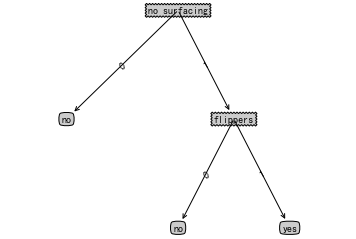

In [69]:
createPlot(mytree)

In [14]:
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in list(secondDict.keys()):
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

In [17]:
classify(mytree, labels, [1,0])

'no'

In [19]:
# 存储决策树

import pickle

def storeTree(inputTree, filename):
    fw = open(filename, 'wb')
    pickle.dump(inputTree, fw)
    fw.close()
    
def grabTree(filename):
    fr = open(filename, 'rb')
    return pickle.load(fr)

In [28]:
storeTree(mytree, 'mytree.txt')

In [20]:
mytree1 = grabTree('mytree.txt')

In [21]:
mytree1

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [56]:
fr = open('.\MLiA_SourceCode\machinelearninginaction\Ch03\lenses.txt', 'r')

In [57]:
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lenseTree = createTree(lenses, lensesLabels)

In [58]:
lenseTree

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'no lenses'}}

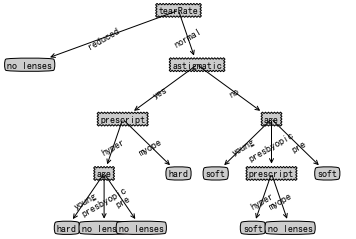

In [59]:
createPlot(lenseTree)